# Lightweight Fine-Tuning Project

This Jupyter Notebook investigates the effectiveness of different fine-tuning techniques for a text classification task. We will compare the performance of three models on the task of classifying SMS messages as spam or not spam:

Base Model: The pre-trained GPT-2 model from Hugging Face, without any fine-tuning.
Fully Fine-Tuned Model: A GPT-2 model fine-tuned on the sms_spam dataset from Hugging Face.
LoRA Fine-Tuned Model: A GPT-2 model fine-tuned on the sms_spam dataset using the Low-Rank Adaptation (LoRA) technique, a Parameter-Efficient Fine-Tuning (PEFT) method.
We will leverage the datasets library from Hugging Face to load the sms_spam dataset and utilize the accuracy metric from the datasets library to evaluate the performance of each model.

This exploration aims to assess whether more efficient fine-tuning matches or improves classification accuracy on the SMS spam task and, if so, whether LoRA offers a more efficient fine-tuning approach compared to full fine-tuning.

## Loading and Evaluating a Foundation Model

In this section, we load the pre-trained GPT2 Hugging Face model and evaluate its performance prior to fine-tuning. This step includes loading an appropriate tokenizer and dataset.

In [2]:
# Install the required versino of datasets if needed (uncomment to run)
# You may need to restart the kernel after running this cell
# ! pip install -q "datasets==2.15.0"

In [1]:
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split

# Load the dataset from Hugging Face
dataset = load_dataset("sms_spam")

# Get the raw dataset
raw_dataset = dataset['train']  # Assuming you want to work with the 'train' split

# Split the dataset into training and testing subsets
train_data, test_data = train_test_split(raw_dataset, test_size=0.2, random_state=42)  # You can adjust test_size and random_state as needed

# Convert the split data into Dataset objects
train_dataset = Dataset.from_dict(train_data)
test_dataset = Dataset.from_dict(test_data)


/Users/andrewwrist/Documents/Projects/AI_ML/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Inspect the first element. For labels, 0 is not spam and 1 is spam
train_dataset[0]

{'sms': "FREE2DAY sexy St George's Day pic of Jordan!Txt PIC to 89080 dont miss out, then every wk a saucy celeb!4 more pics c PocketBabe.co.uk 0870241182716 £3/wk\n",
 'label': 1}

### Pre-process datasets
The dataset needs to be processed by converting all of the text into tokens for the models.

In [3]:
from transformers import GPT2Tokenizer

# Load GPT2 tokenizer
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token  # Assign padding token
gpt2_tokenizer.build_inputs_with_special_tokens(gpt2_tokenizer.all_special_tokens)  # Rebuild vocabulary
 
def tokenize_dataset(dataset):
    '''
    Summary: Tokenize dataset for downstream LLM training and inference
    Input: Un-tokenized dataset
    Output: Tokenized dataset
    '''
    tokenized_dataset = dataset.map(
        lambda x: gpt2_tokenizer(x['sms'], truncation=True), batched=True
    )
    return tokenized_dataset

In [4]:
# Tokenize the train and test datasets
train_tokenized = tokenize_dataset(train_dataset)
test_tokenized = tokenize_dataset(test_dataset)

Map: 100%|██████████| 1115/1115 [00:00<00:00, 10342.54 examples/s]


In [5]:
# Inspect train dataset
train_tokenized

Dataset({
    features: ['sms', 'label', 'input_ids', 'attention_mask'],
    num_rows: 4459
})

In [57]:
from transformers import GPT2ForSequenceClassification

def load_gpt2_model():
    '''
    Summary: load the GPT2 base model for training, modification, and inference
    Output: GPT2 base model
    '''
    gpt2_model_base = GPT2ForSequenceClassification.from_pretrained(
        'gpt2',
        num_labels=2,
        id2label={0: 'not_spam', 1: 'spam'}, # In the dataset, 0 is not spam, and 1 is spam
        label2id={'not_spam': 0, 'spam': 1}
    )

    # Freeze all the parameters of the base model using param.requires_grad = False
    # more info here: https://huggingface.co/transformers/v4.2.2/training.html
    for param in gpt2_model_base.base_model.parameters():
        param.requires_grad = True
    return gpt2_model_base


In [65]:
gpt2_model_base = load_gpt2_model()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
# Use model.score to output the final classification layer for GPT2. In others it may be model.classifier
gpt2_model_base.score

Linear(in_features=768, out_features=2, bias=False)

In [60]:
# Print full model parameters
print(gpt2_model_base)


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): lora.Linear(
            (base_layer): Conv1D()
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=768, out_features=4, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=4, out_features=2304, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
    

### Evaluate base model on test set

Note that all of the training, testing, and inference for this project is performed locally on a CPU

In [ ]:
from datasets import load_metric
import time

# Set torch device to CPU for running on local CPU
device = torch.device('cpu')
metric = load_metric('accuracy', trust_remote_code=True)

def predict(model, tokenized_dataset, pred_max_qty=50):
  """
  Summmary: Function to make predictions on a specific split of the tokenized dataset
  Input:
    model: LLM model
    tokenized_dataset: tokenized dataset
    pred_max_qty: maximum quantity of predictions to predict labels for
  Output:
    predictions: list of predictions
    labels: labels from initial dataset
    accuracy: accuracy of predictions vs labels from dataset
    execution_time: amount of time to make predictions
  """
  model = model.to(device)
  start_time = time.time()
  predictions = [] # Collect predictions
  labels = [] # Collect true labels for evaluation
  for i, datapoint in enumerate(test_tokenized):
    if i >= pred_max_qty:
      break
    input_ids = torch.tensor([datapoint["input_ids"]]).to(device)
    attention_mask = torch.tensor([datapoint["attention_mask"]]).to(device)

    with torch.no_grad():
      outputs = model(input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      predicted_label_index = torch.argmax(logits, dim=-1)
      predicted_label = model.config.id2label[predicted_label_index.item()]
      predictions.append(predicted_label_index.item())
      labels.append(datapoint['label'])
      
  # # Use converted integer labels for metric calculation
  metric.add_batch(predictions=predictions, references=labels)
  accuracy = metric.compute()
  end_time = time.time()
  execution_time = end_time - start_time

  return predictions, labels, accuracy, execution_time


In [67]:
gpt2_base_predictions, gpt2_base_labels, gpt2_base_accuracy, gpt2_base_execution_time = predict(gpt2_model_base, test_tokenized, pred_max_qty=1114)
print("Test Set Accuracy: ", gpt2_base_accuracy)
print("Execution Time: ", gpt2_base_execution_time)

Test Set Accuracy:  {'accuracy': 0.4506283662477558}
Execution Time:  38.88341784477234


The base GPT2 model had an accuracy of 45%. Let's see if we can improve on that with full fine tuning and parameter efficient fine tuning.

### Train model without Fine-Tuning

In this section, the GPT2 base model is fully fine-tuned using the sms_spam dataset. Execution time and accuracy will be recorded to compare with parameter efficient fine-tuning later.

In [10]:
import numpy as np
import time as time
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': (predictions == labels).mean()}

start_time = time.time()

# Use HuggingFace Trainer class for training and evaluating mbase model
gpt2_trainer = Trainer(
    model=gpt2_model_base,
    args=TrainingArguments(
        output_dir="./data/gpt2_sms_class",
        learning_rate=2e-3,
        per_device_train_batch_size=1, # Keeping low for low memory
        per_device_eval_batch_size=1,
        num_train_epochs=1,
        weight_decay=0.01,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
    ),
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=gpt2_tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=gpt2_tokenizer),
    compute_metrics=compute_metrics,
    )

gpt2_trainer.train()
end_time = time.time()
gpt2_full_train_execution_time = end_time - start_time

 11%|█         | 501/4459 [02:57<21:32,  3.06it/s]

{'loss': 0.8707, 'grad_norm': 0.010503172874450684, 'learning_rate': 0.0017757344696120207, 'epoch': 0.11}


 22%|██▏       | 1000/4459 [05:40<17:45,  3.25it/s]

{'loss': 0.5157, 'grad_norm': 0.03326600044965744, 'learning_rate': 0.0015514689392240413, 'epoch': 0.22}


 34%|███▎      | 1500/4459 [08:35<17:58,  2.74it/s]

{'loss': 0.3116, 'grad_norm': 0.027887722477316856, 'learning_rate': 0.001327203408836062, 'epoch': 0.34}


 45%|████▍     | 2000/4459 [11:45<17:54,  2.29it/s]

{'loss': 0.3003, 'grad_norm': 0.010177884250879288, 'learning_rate': 0.0011029378784480825, 'epoch': 0.45}


 56%|█████▌    | 2500/4459 [14:50<11:56,  2.74it/s]

{'loss': 0.1972, 'grad_norm': 0.0015331185422837734, 'learning_rate': 0.0008786723480601032, 'epoch': 0.56}


 67%|██████▋   | 3000/4459 [17:52<08:53,  2.73it/s]

{'loss': 0.1255, 'grad_norm': 0.005527514964342117, 'learning_rate': 0.0006544068176721239, 'epoch': 0.67}


 78%|███████▊  | 3500/4459 [21:00<05:37,  2.84it/s]

{'loss': 0.218, 'grad_norm': 0.022273581475019455, 'learning_rate': 0.00043014128728414443, 'epoch': 0.78}


 90%|████████▉ | 4000/4459 [23:59<02:42,  2.83it/s]

{'loss': 0.1455, 'grad_norm': 0.004164999816566706, 'learning_rate': 0.00020587575689616505, 'epoch': 0.9}


                                                   
100%|██████████| 4459/4459 [29:03<00:00,  2.90it/s]

{'eval_loss': 0.8658758401870728, 'eval_accuracy': 0.8654708520179372, 'eval_runtime': 139.8593, 'eval_samples_per_second': 7.972, 'eval_steps_per_second': 7.972, 'epoch': 1.0}


100%|██████████| 4459/4459 [29:06<00:00,  2.55it/s]

{'train_runtime': 1746.7713, 'train_samples_per_second': 2.553, 'train_steps_per_second': 2.553, 'train_loss': 0.31658849311960363, 'epoch': 1.0}


In [11]:
gpt2_trainer.evaluate()

100%|██████████| 1115/1115 [00:23<00:00, 48.44it/s]


{'eval_loss': 0.8932196497917175,
 'eval_accuracy': 0.863677130044843,
 'eval_runtime': 23.0973,
 'eval_samples_per_second': 48.274,
 'eval_steps_per_second': 48.274,
 'epoch': 1.0}

Note that saved models are only saved locally. They are too large to save to Github.

In [14]:
gpt2_model.save_pretrained('gpt2_full_train_spam')

The fully fine-tuned GPT2 base model performed very well with a 99% accuracy. However, it took over 29 minutes to train on a CPU! Training time would decrease substantially on a GPU, but sometimes infrastructure may be lacking. Additionally, long training times from full fine-tuning and GPUs can be require a lot of energy. Parameter Efficient Fine Tuning (Peft) offers alternatives to potentially achieve similar or even better performance with much less training time. In the next section we'll focus on using LoRA to fine-tune the GPT2 model and see if we can achieve the same high level of accuracy with less training time.

## Performing Parameter-Efficient Fine-Tuning

TODO: In the cells below, create a PEFT model from your loaded model, run a training loop, and save the PEFT model weights.

In [12]:
gpt2_model_base = load_gpt2_model()
gpt2_model_base.score

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=2, bias=False)

In [13]:
import numpy as np
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments
from peft import LoraConfig, TaskType, get_peft_model, LoftQConfig

# Define LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, # Set task type to sequence classification
    r=4, # Set LoRA rank (number of low-rank adaptation matrices)
    lora_alpha=1, # Set learning rate
    lora_dropout=0.1, # Set dropout rate
)

# Create LoRA model
lora_model = get_peft_model(gpt2_model_base, lora_config)

lora_model.print_trainable_parameters()

trainable params: 148,992 || all params: 124,590,336 || trainable%: 0.11958551905663052


/Users/andrewwrist/Documents/Projects/AI_ML/venv/lib/python3.11/site-packages/peft/tuners/lora/layer.py:1059: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Now, instead of training the full model, as we did in the full fine-tuning, we are only training 11.96% of the trainable parameters for LoRA

In [15]:
# Define compute metrics for LoRA evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': (predictions == labels).mean()}

start_time = time.time()
# Use HuggingFace Trainer class for training and evaluating LoRA model
lora_trainer = Trainer(
    model=lora_model,
    args=TrainingArguments(
        output_dir="./data/lora_gpt2",
        learning_rate=2e-3,
        per_device_train_batch_size=1, # Keeping low for low memory
        per_device_eval_batch_size=1,
        num_train_epochs=1,
        weight_decay=0.01,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
    ),
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    tokenizer=gpt2_tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=gpt2_tokenizer),
    compute_metrics=compute_metrics,
    )

lora_trainer.train()

end_time = time.time()
lora_train_execution_time = end_time - start_time

 11%|█         | 501/4459 [01:02<05:59, 11.00it/s]

{'loss': 0.5542, 'grad_norm': 2.3128361590352142e-06, 'learning_rate': 0.0017757344696120207, 'epoch': 0.11}


 22%|██▏       | 1002/4459 [01:48<05:02, 11.44it/s]

{'loss': 0.1904, 'grad_norm': 2.759829476417508e-05, 'learning_rate': 0.0015514689392240413, 'epoch': 0.22}


 34%|███▎      | 1501/4459 [02:34<04:17, 11.48it/s]

{'loss': 0.1371, 'grad_norm': 0.025812074542045593, 'learning_rate': 0.001327203408836062, 'epoch': 0.34}


 45%|████▍     | 2002/4459 [03:21<04:18,  9.52it/s]

{'loss': 0.0882, 'grad_norm': 3.5229041372986103e-07, 'learning_rate': 0.0011029378784480825, 'epoch': 0.45}


 56%|█████▌    | 2501/4459 [04:07<04:04,  8.00it/s]

{'loss': 0.0918, 'grad_norm': 1.5261623047990724e-05, 'learning_rate': 0.0008786723480601032, 'epoch': 0.56}


 67%|██████▋   | 3001/4459 [04:51<02:04, 11.70it/s]

{'loss': 0.0484, 'grad_norm': 5.067917300038971e-06, 'learning_rate': 0.0006544068176721239, 'epoch': 0.67}


 79%|███████▊  | 3501/4459 [05:37<01:21, 11.72it/s]

{'loss': 0.0853, 'grad_norm': 0.00038298757863231003, 'learning_rate': 0.00043014128728414443, 'epoch': 0.78}


 90%|████████▉ | 4002/4459 [06:22<00:41, 11.14it/s]

{'loss': 0.1006, 'grad_norm': 6.577976496835447e-10, 'learning_rate': 0.00020587575689616505, 'epoch': 0.9}


                                                   
100%|██████████| 4459/4459 [07:31<00:00, 11.20it/s]

{'eval_loss': 0.6739403009414673, 'eval_accuracy': 0.905829596412556, 'eval_runtime': 27.8562, 'eval_samples_per_second': 40.027, 'eval_steps_per_second': 40.027, 'epoch': 1.0}


100%|██████████| 4459/4459 [07:32<00:00,  9.85it/s]

{'train_runtime': 452.4709, 'train_samples_per_second': 9.855, 'train_steps_per_second': 9.855, 'train_loss': 0.15419702643261654, 'epoch': 1.0}


In [16]:
lora_trainer.evaluate()

100%|██████████| 1115/1115 [00:25<00:00, 43.38it/s]


{'eval_loss': 0.6740188598632812,
 'eval_accuracy': 0.9049327354260089,
 'eval_runtime': 26.4767,
 'eval_samples_per_second': 42.113,
 'eval_steps_per_second': 42.113,
 'epoch': 1.0}

The LoRA model actually performed better than the full fine-tuned model in just a quarter of the time (7.5 minutes vs 29 minutes)! Not only are we saving time and improving performance with this PEFT technique, but we're also saving valuable computational and energy resources. In the next section, we will investigate further by performing inference and visually comparing the three models.

In [22]:
lora_model.save_pretrained('gpt2_lora_email_spam')

## Performing Inference with a PEFT Model

In this section, we will load the saved PEFT model weights and evaluate the performance of the trained PEFT model and offer a visual comparison of performance against the other models.

In [23]:
from peft import PeftModelForSequenceClassification
from transformers import AutoModelForSequenceClassification, DefaultDataCollator
from transformers import GPT2Config
# lora_model_out = AutoModelForSequenceClassification.from_pretrained('gpt2_lora_email_spam')

# Configure saved LoRA model for loading
lora_config = GPT2Config.from_pretrained('gpt2_lora_email_spam/adapter_config.json')

# Add padding token
lora_config.pad_token_id = lora_config.eos_token_id

# Load saved LoRA model
lora_model_out = GPT2ForSequenceClassification.from_pretrained('gpt2_lora_email_spam', config = lora_config)

# Add padding token to the tokenizer
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
# Make predictions on the test set and calculate accuracy
lora_predictions, lora_labels, lora_accuracy, lora_execution_time = predict(lora_model_out, test_tokenized, pred_max_qty=1114)
print("Test Set Accuracy: ", lora_accuracy)
print("Execution Time: ", lora_execution_time)

Test Set Accuracy:  {'accuracy': 0.9937163375224417}
Execution Time:  40.78544282913208


In [51]:
# Make predictions on the test set and calculate accuracy
gpt2_fulltrain_predictions, gpt2_fulltrain_labels, gpt2_fulltrain_accuracy, gpt2_fulltrain_execution_time = predict(gpt2_model, test_tokenized, pred_max_qty=1114)
# print("Test Set Predictions: ", base_predictions)
# print("Test Set Labels: ", base_labels)
print("Test Set Accuracy: ", gpt2_fulltrain_accuracy)
print("Execution Time: ", gpt2_fulltrain_execution_time)

Test Set Accuracy:  {'accuracy': 0.9901256732495511}
Execution Time:  40.30510878562927


In [74]:
import pandas as pd

review_count = slice(26, 36) # Define a slice that has a good mix of spam and not spam
review_set = test_tokenized[review_count]

# Set up dataframe to compare labels and predictions with SMS messages from the test dataset
df_review = pd.DataFrame(
    {
        'sms': [item for item in review_set['sms']],
        'labels': [item for item in review_set['label']],
        'gpt2_base_predictions': gpt2_base_predictions[review_count],
        'gpt2_full_tune': gpt2_fulltrain_predictions[review_count],
        'LoRA': lora_predictions[review_count]
        
    }
)
pd.set_option('display.max_colwidth', None)
display(df_review)

,sms,labels,gpt2_base_predictions,gpt2_full_tune,LoRA
0,Kit Strip - you have been billed 150p. Netcollex Ltd. PO Box 1013 IG11 OJA\n,1,1,1,1
1,URGENT This is our 2nd attempt to contact U. Your £900 prize from YESTERDAY is still awaiting collection. To claim CALL NOW 09061702893. ACL03530150PM\n,1,1,1,1
2,"Some friends want me to drive em someplace, probably take a while\n",0,1,0,0
3,Dunno y u ask me.\n,0,1,0,0
4,Call Germany for only 1 pence per minute! Call from a fixed line via access number 0844 861 85 85. No prepayment. Direct access!\n,1,1,1,1
5,Yes princess! I want to catch you with my big strong hands...\n,0,1,0,0
6,"Dear,shall mail tonite.busy in the street,shall update you tonite.things are looking ok.varunnathu edukkukayee raksha ollu.but a good one in real sense.\n",0,0,1,0
7,(You didn't hear it from me)\n,0,1,0,0
8,"I promise to take good care of you, princess. I have to run now. Please send pics when you get a chance. Ttyl!\n",0,0,0,0
9,"all the lastest from Stereophonics, Marley, Dizzee Racal, Libertines and The Strokes! Win Nookii games with Flirt!! Click TheMob WAP Bookmark or text WAP to 82468\n",1,1,1,1


This selection of 10 spam messages was selected as it was a fairly even distribution between spam (1) and not spam (0). You can observe in the selection of SMS examples above, that LoRA perfromed very well, with 100% accuracy across the SMS messages, correctly identifying 4 of the spam messages as spam. the fully-tuned GPT2 model predicted one extra spam message, while the base model, significantly overpredicted, labeling 4 incorrectly as spam. 

In [77]:
# Set train times for plot
gpt2_full_train_time = 29 * 60
LoRA_train_time = 7.5 * 60
gpt2_base_train_time = 0


/var/folders/dz/71j5m95x01d2wwbm3pz62vz80000gn/T/ipykernel_11896/4128727213.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(x_times, rotation=45)  # Set labels and rotate
/var/folders/dz/71j5m95x01d2wwbm3pz62vz80000gn/T/ipykernel_11896/4128727213.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(x_accuracies, rotation=45)  # Set labels and rotate


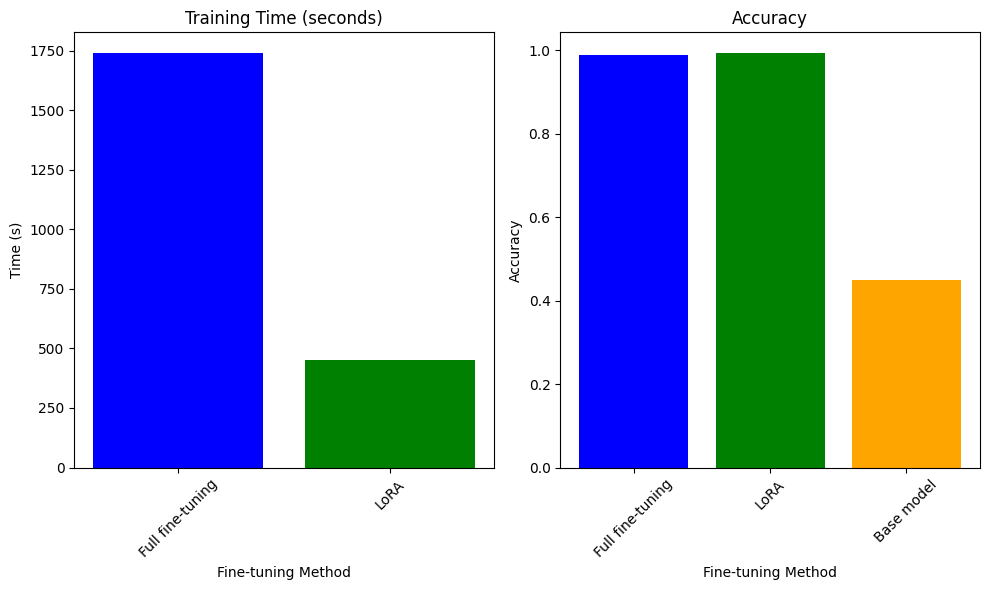

In [93]:
import matplotlib.pyplot as plt

# Training times (seconds)
training_times = {
    # 'Base model': gpt2_base_train_time,
    'Full fine-tuning': gpt2_full_train_time,
    'LoRA': LoRA_train_time
}

# Accuracies
accuracies = {
    'Full fine-tuning': gpt2_fulltrain_accuracy['accuracy'],
    'LoRA': lora_accuracy['accuracy'],
    'Base model': gpt2_base_accuracy['accuracy']
    }

# Create separate subplots for training times and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Bar chart for training times
x_times = training_times.keys()
y_times = training_times.values()
ax1.bar(x_times, y_times, color=['blue', 'green', 'orange'])
ax1.set_title('Training Time (seconds)')
ax1.set_xlabel('Fine-tuning Method')
ax1.set_ylabel('Time (s)')
ax1.set_xticklabels(x_times, rotation=45)  # Set labels and rotate


# Bar chart for accuracies
x_accuracies = accuracies.keys()
y_accuracies = accuracies.values()
# ax2.bar(x_labels, y_accuracies, color=['blue', 'green', 'orange'])
ax2.bar(x_accuracies, y_accuracies, color=['blue', 'green', 'orange'])
ax2.set_title('Accuracy')
ax2.set_xlabel('Fine-tuning Method')
ax2.set_ylabel('Accuracy')
ax2.set_xticklabels(x_accuracies, rotation=45)  # Set labels and rotate

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


Our experiments demonstrated that the Parameter-Efficient Fine-Tuning (PEFT) method using LoRA achieved comparable performance to full fine-tuning on the GPT-2 model for SMS spam classification on Hugging Face. Both models achieved 99% accuracy on the test set. However, the LoRA model required only a quarter of the training time compared to full fine-tuning. This significant reduction in training time translates to lower energy consumption. Notably, the base GPT-2 model, without fine-tuning, performed poorly on the task, achieving only 45% accuracy.Our experiments demonstrated that the Parameter-Efficient Fine-Tuning (PEFT) method using LoRA achieved comparable performance to full fine-tuning on the GPT-2 model for SMS spam classification on Hugging Face. Both models achieved 99% accuracy on the test set. However, the LoRA model required only a quarter of the training time compared to full fine-tuning. This significant reduction in training time translates to lower energy consumption. Notably, the base GPT-2 model, without fine-tuning, performed poorly on the task, achieving only 45% accuracy.


This project was part of the Udacity Generative AI Nanodegree. Special thanks for Udacity for the training materials and making this work possible.